<h1 style="margin-left: 20px; color:blue">1. Importing the required libraries</h1>

In [1]:
# Importing the required libraries
import requests
import zipfile
import io
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
from IPython.display import display, HTML
from typing import Optional, Union, Dict, Set, Tuple
from datetime import date, datetime
import upsetplot                            #Intesection analysis
import missingno as msno                    #Visualize missing values
import warnings
import featuretools as ft                   #Feature Engineering
%matplotlib inline     
import numpy as np
import pandas as pd
import scipy as sp
import warnings 
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True)

<h1 style="margin-left: 20px; color:blue">2. Loading the data into the data frame</h1>

In [2]:
# Define the URL of the ZIP file
url_zip_file = 'https://archive.ics.uci.edu/static/public/186/wine+quality.zip'

# Download the ZIP file
response = requests.get(url_zip_file)
if response.status_code == 200:
    # Create a BytesIO object from the downloaded content
    zip_file = io.BytesIO(response.content)
else:
    raise Exception(f"Failed to download the file. Status code: {response.status_code}")

# Create a dictionary to store the DataFrames
dataframes = {}

# Open the ZIP file from the BytesIO object
with zipfile.ZipFile(zip_file, 'r') as z:
    # Iterate through each file in the ZIP archive
    for file_name in z.namelist():
        # Check if the file is a CSV file
        if file_name.endswith('.csv'):
            # Read the CSV file into a DataFrame with the correct delimiter
            with z.open(file_name) as f:
                df = pd.read_csv(f, delimiter=';')
                # Store the DataFrame in the dictionary
                dataframes[file_name] = df


In [3]:
# Looking at CSV Files in a ZIP Archive:
dataframes.keys()

dict_keys(['winequality-red.csv', 'winequality-white.csv'])

In [4]:
# Access the DataFrames using the dictionary keys
winequality_red = dataframes.get('winequality-red.csv')
winequality_white = dataframes.get('winequality-white.csv')

In [5]:
# Add a column for wine type
winequality_red['wine_type'] = 'red'
winequality_white['wine_type'] = 'white'

# Combine the dataframes
winequality = pd.concat([winequality_red, winequality_white], ignore_index=True)
winequality

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white


<h1 style="margin-left: 20px; color:blue">3. Exploratory Data Analysis</h1>

<h3 style="margin-left: 200px; color:lime">3.1 Primary data analysis</h3>

In [6]:
def primary_analysis(df: pd.DataFrame) -> None:
    """
    Perform primary analysis on a DataFrame by computing various statistics and displaying them.

    Parameters:
    df (DataFrame): The input DataFrame to analyze.

    Returns:
    None
    """
    # Generate descriptive statistics
    desc = df.describe(include='all').transpose()
    
    # Add columns for non-null and null value counts
    desc['non-null'] = df.notnull().sum()
    desc['null'] = df.isnull().sum()
    
    # Add column for data types
    desc['dtype'] = df.dtypes
    
    # Define the columns to display in the result
    columns = ['non-null', 'null', 'dtype', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
    
    # Optionally include 'unique', 'top', and 'freq' if they exist in the description
    if 'unique' in desc.columns:
        columns.append('unique')
    if 'top' in desc.columns:
        columns.append('top')
    if 'freq' in desc.columns:
        columns.append('freq')
    
    # Create a DataFrame with the selected columns
    info_df = desc[columns]
    
    # Display the resulting DataFrame
    display(info_df)

primary_analysis(winequality)

,non-null,null,dtype,count,mean,std,min,25%,50%,75%,max,unique,top,freq
fixed acidity,6497,0,float64,6497.0,7.215307,1.296434,3.8,6.4,7.0,7.7,15.9,NaN,NaN,NaN
volatile acidity,6497,0,float64,6497.0,0.339666,0.164636,0.08,0.23,0.29,0.4,1.58,NaN,NaN,NaN
citric acid,6497,0,float64,6497.0,0.318633,0.145318,0.0,0.25,0.31,0.39,1.66,NaN,NaN,NaN
residual sugar,6497,0,float64,6497.0,5.443235,4.757804,0.6,1.8,3.0,8.1,65.8,NaN,NaN,NaN
chlorides,6497,0,float64,6497.0,0.056034,0.035034,0.009,0.038,0.047,0.065,0.611,NaN,NaN,NaN
free sulfur dioxide,6497,0,float64,6497.0,30.525319,17.7494,1.0,17.0,29.0,41.0,289.0,NaN,NaN,NaN
total sulfur dioxide,6497,0,float64,6497.0,115.744574,56.521855,6.0,77.0,118.0,156.0,440.0,NaN,NaN,NaN
density,6497,0,float64,6497.0,0.994697,0.002999,0.98711,0.99234,0.99489,0.99699,1.03898,NaN,NaN,NaN
pH,6497,0,float64,6497.0,3.218501,0.160787,2.72,3.11,3.21,3.32,4.01,NaN,NaN,NaN
sulphates,6497,0,float64,6497.0,0.531268,0.148806,0.22,0.43,0.51,0.6,2.0,NaN,NaN,NaN


<span style="margin-left: 20px; color:red">The citric_acid column contains zero values</span>

In [7]:
zero_citric_acid_count = (winequality['citric acid'] == 0).sum()
print(f'The citric acid column contains {zero_citric_acid_count} zero values.')

The citric acid column contains 151 zero values.


<h3 style="margin-left: 200px; color:lime">3.2 Renaming the columns</h3>

In [8]:
new_columns = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
               'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
               'pH', 'sulphates', 'alcohol', 'quality', 'wine_type']
winequality.columns = new_columns
winequality.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


<h3 style="margin-left: 200px; color:lime">3.3 Visualize missing values</h3>

<Figure size 1000x600 with 0 Axes>

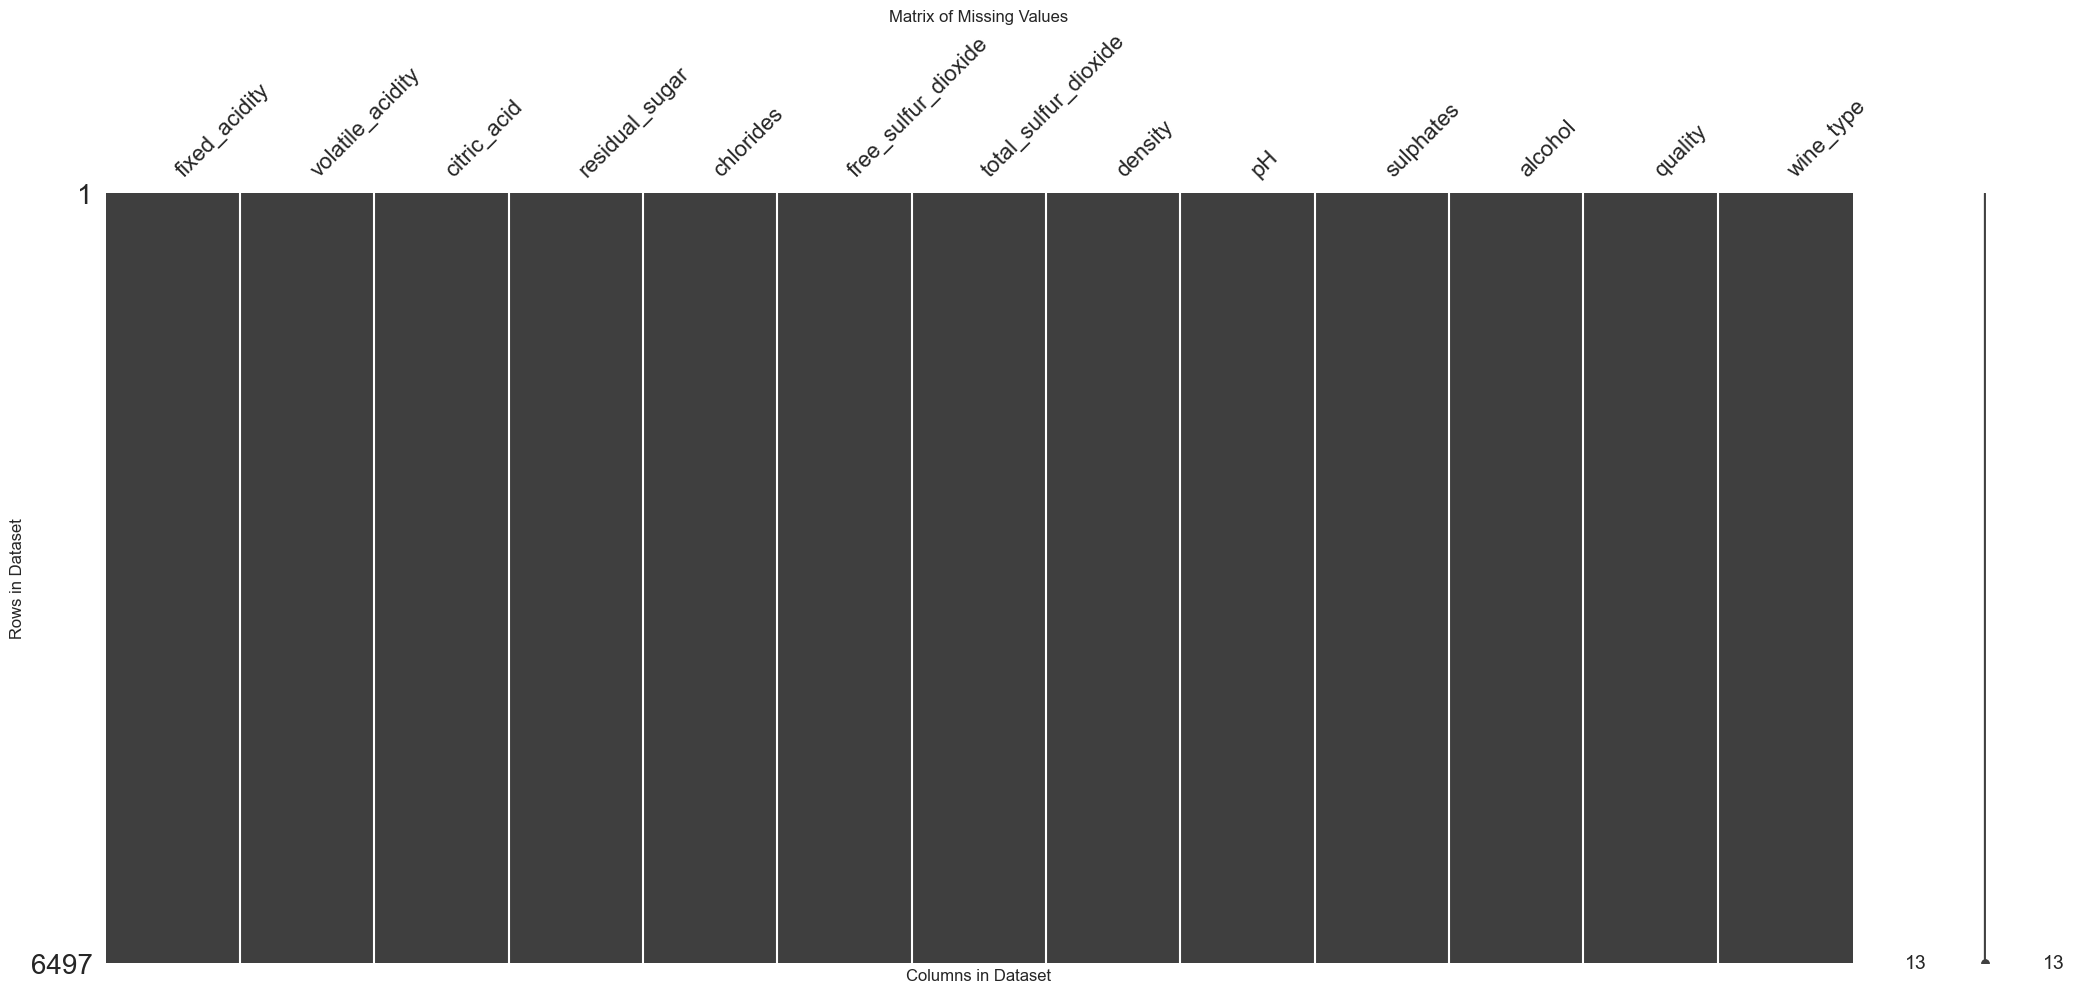

In [9]:
plt.figure(figsize=(10, 6))
msno.matrix(winequality)
plt.title('Matrix of Missing Values')
plt.xlabel('Columns in Dataset')
plt.ylabel('Rows in Dataset')
plt.show()

<h3 style="margin-left: 200px; color:lime">3.4 Dropping the duplicate rows</h3>

In [10]:
duplicate_rows_df = winequality[winequality.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape)
primary_analysis(duplicate_rows_df)

number of duplicate rows:  (1177, 13)


,non-null,null,dtype,count,mean,std,min,25%,50%,75%,max,unique,top,freq
fixed_acidity,1177,0,float64,1177.0,7.215888,1.186262,4.9,6.5,7.0,7.6,15.5,NaN,NaN,NaN
volatile_acidity,1177,0,float64,1177.0,0.31949,0.145577,0.08,0.22,0.28,0.38,1.0,NaN,NaN,NaN
citric_acid,1177,0,float64,1177.0,0.319261,0.136753,0.0,0.25,0.3,0.38,0.91,NaN,NaN,NaN
residual_sugar,1177,0,float64,1177.0,7.227528,5.436191,0.6,2.1,6.3,12.0,31.6,NaN,NaN,NaN
chlorides,1177,0,float64,1177.0,0.053069,0.024953,0.012,0.039,0.048,0.059,0.415,NaN,NaN,NaN
free_sulfur_dioxide,1177,0,float64,1177.0,32.73407,17.331987,1.0,20.0,32.0,44.0,108.0,NaN,NaN,NaN
total_sulfur_dioxide,1177,0,float64,1177.0,123.137213,54.784264,6.0,90.0,128.0,162.0,256.0,NaN,NaN,NaN
density,1177,0,float64,1177.0,0.995426,0.00304,0.98794,0.993,0.99576,0.99784,1.0103,NaN,NaN,NaN
pH,1177,0,float64,1177.0,3.190646,0.159746,2.79,3.08,3.18,3.29,3.72,NaN,NaN,NaN
sulphates,1177,0,float64,1177.0,0.521827,0.14418,0.26,0.42,0.5,0.59,1.95,NaN,NaN,NaN


In [11]:
winequality = winequality.drop_duplicates()
print("number of non-duplicate rows: ", winequality.shape)

number of non-duplicate rows:  (5320, 13)


<h3 style="margin-left: 200px; color:lime">3.5 Identify categorical columns in a DataFrame</h3>

In [12]:
from typing import List

def identify_categorical(df: pd.DataFrame, threshold: float = 0.01) -> List[str]:
    """
    Identify categorical columns in a DataFrame.

    A column is considered categorical if the ratio of unique values to total number of rows is less than the threshold,
    or if the column's data type is 'object'.

    Parameters:
    df (DataFrame): The input DataFrame to analyze.
    threshold (float): The threshold ratio of unique values to total number of rows for a column to be considered categorical. Default is 0.01.

    Returns:
    List[str]: A list of column names that are considered categorical.

    Example:
    >>> df = pd.DataFrame({
    >>>     'A': [1, 2, 3, 4],
    >>>     'B': ['cat', 'dog', 'cat', 'dog'],
    >>>     'C': [1.1, 2.2, 3.3, 4.4]
    >>> })
    >>> categorical_columns = identify_categorical(df)
    >>> print(categorical_columns)
    ['B']
    """
    categorical_columns = []  # Initialize an empty list to store the names of categorical columns

    # Iterate over each column in the DataFrame
    for column in df.columns:
        # Calculate the ratio of unique values to the total number of rows
        unique_ratio = df[column].nunique() / df.shape[0]
        
        # Check if the column should be considered categorical
        if unique_ratio < threshold or df[column].dtype == 'object':
            categorical_columns.append(column)
    
    return categorical_columns

In [13]:
categorical_columns = identify_categorical(winequality_red)
categorical_columns

['quality', 'wine_type']

<h3 style="margin-left: 200px; color:lime">3.5 Detecting Outliers</h3>

In [14]:
Q1 = winequality.loc[:, ~winequality.columns.isin(categorical_columns)].quantile(0.25)
Q3 = winequality.loc[:, ~winequality.columns.isin(categorical_columns)].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

fixed_acidity            1.30000
volatile_acidity         0.18000
citric_acid              0.16000
residual_sugar           5.70000
chlorides                0.02800
free_sulfur_dioxide     25.00000
total_sulfur_dioxide    79.25000
density                  0.00457
pH                       0.22000
sulphates                0.17000
alcohol                  1.90000
dtype: float64


In [15]:
# IQR = Q3 - Q1

# Determine the lower and upper bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtering winequality based on the bounds
winequality_without_outliers = winequality[~((winequality.loc[:, ~winequality.columns.isin(categorical_columns)] < lower_bound) | (winequality.loc[:, ~winequality.columns.isin(categorical_columns)] > upper_bound)).any(axis=1)]

In [16]:
# Check the shape of filtered dataframe
winequality_without_outliers.shape

(4226, 13)

In [17]:
winequality.shape

(5320, 13)

<h3 style="margin-left: 200px; color:lime">3.6 Plot different features against one another (scatter), against frequency (histogram)</h3>

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix for numeric columns
corr = winequality.select_dtypes('number').corr()

# Define the colormap
cmap = sns.diverging_palette(5, 250, as_cmap=True)

# Function to magnify table elements on hover
def magnify():
    return [dict(selector="th",
                 props=[("font-size", "8pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

# Display the correlation matrix with styling
corr_styled = corr.style.background_gradient(cmap, axis=1)\
                        .format(precision=3)\
                        .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
                        .set_caption("Correlation Matrix Heatmap")\
                        .set_table_styles(magnify())

# Display the styled correlation matrix
display(corr_styled)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
fixed_acidity,1.000,0.215,0.330,-0.104,0.289,-0.282,-0.327,0.478,-0.271,0.305,-0.103,-0.080
volatile_acidity,0.215,1.000,-0.384,-0.164,0.368,-0.349,-0.401,0.308,0.247,0.228,-0.065,-0.265
citric_acid,0.330,-0.384,1.000,0.146,0.055,0.131,0.195,0.095,-0.345,0.059,-0.005,0.098
residual_sugar,-0.104,-0.164,0.146,1.000,-0.123,0.399,0.488,0.521,-0.235,-0.175,-0.305,-0.057
chlorides,0.289,0.368,0.055,-0.123,1.000,-0.187,-0.270,0.372,0.026,0.405,-0.270,-0.202
free_sulfur_dioxide,-0.282,-0.349,0.131,0.399,-0.187,1.000,0.720,0.006,-0.142,-0.198,-0.170,0.054
total_sulfur_dioxide,-0.327,-0.401,0.195,0.488,-0.270,0.720,1.000,0.007,-0.223,-0.276,-0.249,-0.050
density,0.478,0.308,0.095,0.521,0.372,0.006,0.007,1.000,0.034,0.283,-0.668,-0.326
pH,-0.271,0.247,-0.345,-0.235,0.026,-0.142,-0.223,0.034,1.000,0.168,0.097,0.040
sulphates,0.305,0.228,0.059,-0.175,0.405,-0.198,-0.276,0.283,0.168,1.000,-0.017,0.042


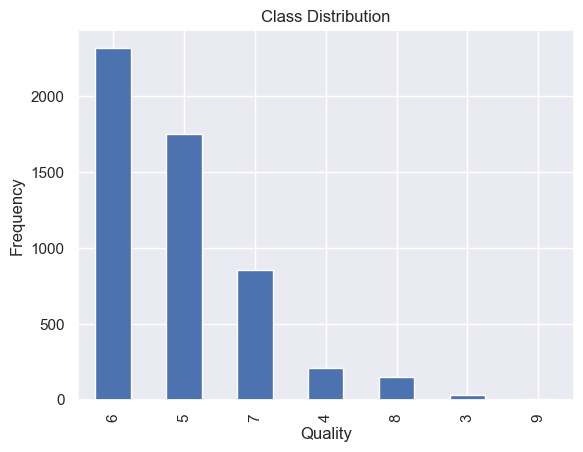

In [19]:
# Анализ распределения классов
class_distribution = winequality['quality'].value_counts()
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.show()

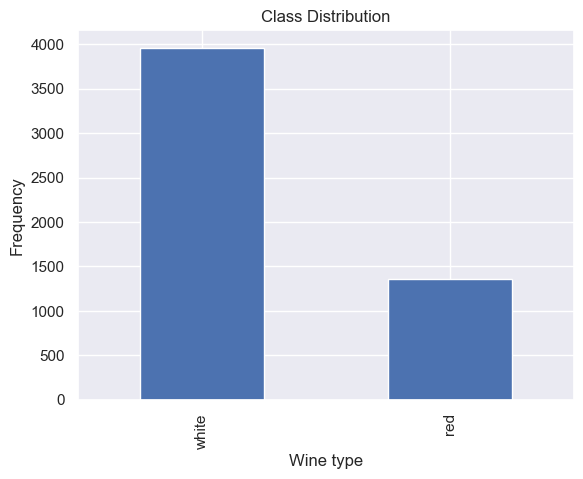

In [20]:
# Анализ распределения классов
class_distribution = winequality['wine_type'].value_counts()
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Wine type')
plt.ylabel('Frequency')
plt.show()

<h1 style="margin-left: 20px; color:blue">4. Feature Engineering</h1>

In [35]:
# Convert 'wine_type' to dummy variables
wine_type_dummies = pd.get_dummies(winequality['wine_type'])

# Convert boolean to integers
wine_type_dummies = wine_type_dummies.astype(int)

# Replace 1 with 1 and 0 with -1
wine_type_dummies_custom = wine_type_dummies.replace({1: 1, 0: -1})

# Concatenate the original DataFrame with the custom dummy variables DataFrame
winequality_with_dummies = pd.concat([winequality, wine_type_dummies_custom], axis=1)
winequality_with_dummies = winequality_with_dummies.drop(columns='wine_type')
winequality_with_dummies

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,red,white
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,1,-1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,1,-1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,1,-1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,1,-1
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.99780,3.51,0.56,9.4,5,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,-1,1
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,-1,1
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,-1,1
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,-1,1


<h1 style="margin-left: 20px; color:blue">5. Building Linear Regression </h1>


<h3 style="margin-left: 200px; color:lime">5.1 Building a simple linear model using `statsmodels`</h3>

In [21]:
import statsmodels.formula.api as smf
formula = 'quality ~ fixed_acidity + volatile_acidity + citric_acid + residual_sugar + ' \
          'chlorides + free_sulfur_dioxide + total_sulfur_dioxide + density + ' \
          'pH + sulphates + alcohol'
models = smf.ols(formula,data=winequality)
fitteds = models.fit()
results = fitteds.summary()
print(results)

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     214.3
Date:                Sun, 30 Jun 2024   Prob (F-statistic):               0.00
Time:                        19:22:37   Log-Likelihood:                -5889.3
No. Observations:                5320   AIC:                         1.180e+04
Df Residuals:                    5308   BIC:                         1.188e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               56.8729 

In [22]:
# Find the set of features where R-squared is maximum
features = {'fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
            'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
            'pH', 'sulphates', 'alcohol'}

# Recursive function to iterate through all variable combinations
def brute_force(params: set, formula: str, result: set) -> None:
    """
    Recursively generates all combinations of variables for regression formula.
    
    Args:
    - params (set): Set of variables to consider in the current iteration.
    - formula (str): Current formula being constructed recursively.
    - result (set): Set to store all generated formula combinations.
    
    Returns:
    None
    """
    if not params:
        result.add(formula.lstrip('+ '))
        return
    else:
        new_params = params.copy()
        for var in params:
            new_params.remove(var)
            brute_force(new_params, formula + ' + ' + var, result)
            brute_force(new_params, formula, result)

res = set()
brute_force(features, '', res)
res.remove('')

results = {}

# Calculate Adjusted R-Square for each combination
for formula in res:
    lm = smf.ols(formula='quality ~ ' + formula, data=winequality).fit()
    results[formula] = f'{lm.rsquared_adj:.5f}'

max_formula = max(results, key=lambda x: results[x])
print(f'The combination with the highest Adjusted R-Square is: [{max_formula} \t Adjusted R-Square {results[max_formula]}]')


The combination with the highest Adjusted R-Square is: [sulphates + residual_sugar + chlorides + pH + fixed_acidity + density + alcohol + volatile_acidity + free_sulfur_dioxide + total_sulfur_dioxide 	 Adjusted R-Square 0.30610]


<h3 style="margin-left: 200px; color:lime">5.2 Constructing a linear model using the winequality_without_outliers dataset</h3>

In [25]:
formula = 'quality ~ fixed_acidity + volatile_acidity + citric_acid + residual_sugar + ' \
          'chlorides + free_sulfur_dioxide + total_sulfur_dioxide + density + ' \
          'pH + sulphates + alcohol'
models = smf.ols(formula,data=winequality_without_outliers)
fitteds = models.fit()
results = fitteds.summary()
print(results)

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     167.9
Date:                Sun, 30 Jun 2024   Prob (F-statistic):          2.08e-322
Time:                        19:25:17   Log-Likelihood:                -4637.1
No. Observations:                4226   AIC:                             9298.
Df Residuals:                    4214   BIC:                             9374.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               88.6699 

In [36]:
# Find the set of features where R-squared is maximum
features = {'fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
            'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
            'pH', 'sulphates', 'alcohol'}

# Recursive function to iterate through all variable combinations
def brute_force(params: set, formula: str, result: set) -> None:
    """
    Recursively generates all combinations of variables for regression formula.
    
    Args:
    - params (set): Set of variables to consider in the current iteration.
    - formula (str): Current formula being constructed recursively.
    - result (set): Set to store all generated formula combinations.
    
    Returns:
    None
    """
    if not params:
        result.add(formula.lstrip('+ '))
        return
    else:
        new_params = params.copy()
        for var in params:
            new_params.remove(var)
            brute_force(new_params, formula + ' + ' + var, result)
            brute_force(new_params, formula, result)

res = set()
brute_force(features, '', res)
res.remove('')

results = {}

# Calculate Adjusted R-Square for each combination
for formula in res:
    lm = smf.ols(formula='quality ~ ' + formula, data=winequality_without_outliers).fit()
    results[formula] = f'{lm.rsquared_adj:.5f}'

max_formula = max(results, key=lambda x: results[x])
print(f'The combination with the highest Adjusted R-Square is: [{max_formula} \t Adjusted R-Square {results[max_formula]}]')


The combination with the highest Adjusted R-Square is: [sulphates + residual_sugar + pH + fixed_acidity + density + alcohol + volatile_acidity + free_sulfur_dioxide + total_sulfur_dioxide 	 Adjusted R-Square 0.30311]


<h3 style="margin-left: 200px; color:lime">5.3 Constructing a linear model using the winequality_with_dummies dataset</h3>

In [39]:
formula = 'quality ~ fixed_acidity + volatile_acidity + citric_acid + residual_sugar + ' \
          'chlorides + free_sulfur_dioxide + total_sulfur_dioxide + density + ' \
          'pH + sulphates + alcohol + red + white'
models = smf.ols(formula,data=winequality_with_dummies)
fitteds = models.fit()
results = fitteds.summary()
print(results)

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     199.8
Date:                Sun, 30 Jun 2024   Prob (F-statistic):               0.00
Time:                        19:55:07   Log-Likelihood:                -5875.2
No. Observations:                5320   AIC:                         1.178e+04
Df Residuals:                    5307   BIC:                         1.186e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               99.7766 

<h3 style="margin-left: 200px; color:lime">5.4 Constructing a linear model using the winequality_with_dummies dataset and scaling data</h3>

In [45]:
from sklearn.preprocessing import StandardScaler

def scale_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Scales the features in the input DataFrame.

    This function takes a DataFrame, scales its features, and returns a new DataFrame
    with the scaled features. The scaling is performed such that the data has a mean
    of 0 and a standard deviation of 1.

    Parameters:
    df (pd.DataFrame): The input DataFrame with features to be scaled.

    Returns:
    pd.DataFrame: DataFrame with scaled features.
    """
    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_array, columns=df.columns, index=df.index)
    return scaled_df


In [47]:
winequality_with_dummies_scaled = scale_features(winequality_with_dummies)
winequality_with_dummies_scaled

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,red,white
0,0.140064,2.115349,-2.164515,-0.699699,0.523880,-1.069272,-1.411143,1.100996,1.779304,0.177941,-0.969152,-0.904497,1.707233,-1.707233
1,0.443199,3.185297,-2.164515,-0.544135,1.120736,-0.282905,-0.829839,0.763753,-0.153797,0.979389,-0.631833,-0.904497,1.707233,-1.707233
2,0.443199,2.471998,-1.892672,-0.610806,0.957957,-0.844596,-1.058837,0.831202,0.220351,0.779027,-0.631833,-0.904497,1.707233,-1.707233
3,3.019841,-0.381197,1.641293,-0.699699,0.496751,-0.732258,-0.953146,1.168444,-0.403229,0.311515,-0.631833,0.232268,1.707233,-1.707233
5,0.140064,1.877583,-2.164515,-0.721923,0.496751,-0.956934,-1.305451,1.100996,1.779304,0.177941,-0.969152,-0.904497,1.707233,-1.707233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,-0.769339,-0.797288,-0.193650,-0.766370,-0.479922,-0.339074,-0.389457,-1.145039,0.282710,-0.222784,0.548783,0.232268,-0.585743,0.585743
6493,-0.466204,-0.143431,0.282076,0.655929,-0.262884,1.514508,0.949305,0.122993,-0.465588,-0.489933,-0.800493,-0.904497,-0.585743,0.585743
6494,-0.541988,-0.618963,-0.873259,-0.855263,-0.425662,-0.002059,-0.054766,-0.672899,-1.463317,-0.489933,-0.969152,0.232268,-0.585743,0.585743
6495,-1.299824,-0.321755,-0.125689,-0.877487,-0.941128,-0.563750,-0.072382,-1.971283,0.719216,-1.024232,1.898059,1.369032,-0.585743,0.585743


In [48]:
formula = 'quality ~ fixed_acidity + volatile_acidity + citric_acid + residual_sugar + ' \
          'chlorides + free_sulfur_dioxide + total_sulfur_dioxide + density + ' \
          'pH + sulphates + alcohol + red + white'
models = smf.ols(formula,data=winequality_with_dummies_scaled)
fitteds = models.fit()
results = fitteds.summary()
print(results)

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     199.8
Date:                Sun, 30 Jun 2024   Prob (F-statistic):               0.00
Time:                        20:53:52   Log-Likelihood:                -6557.2
No. Observations:                5320   AIC:                         1.314e+04
Df Residuals:                    5307   BIC:                         1.323e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             5.967e-15 

<h3 style="margin-left: 200px; color:lime">5.5 Constructing  a linear model using the "winequality_with_dummies" dataset, with incorporate regularization techniques to manage overfitting and improve generalization. Regularization methods such as Ridge (L2) or Lasso (L1) regression can help achieve this goal effectively</h3>

In [49]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Assuming winequality_red is your DataFrame

# Split data into predictors (X) and target (y)
#X = winequality_red.drop(columns=['quality'])
X = winequality_with_dummies_scaled.drop(columns='quality')
y = winequality['quality']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ridge Regression with GridSearchCV for hyperparameter tuning

ridge_params = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]}  # Different alpha values to try

ridge_grid = GridSearchCV(Ridge(), param_grid=ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)

print("Ridge Regression:")
print("Best Parameters:", ridge_grid.best_params_)
print("Best Cross-Validated RMSE:", (-ridge_grid.best_score_) ** 0.5)

# Calculate R-squared and adjusted R-squared for Ridge Regression
best_ridge_model = ridge_grid.best_estimator_
ridge_y_pred = best_ridge_model.predict(X_test)
ridge_rmse = mean_squared_error(y_test, ridge_y_pred, squared=False)
ridge_r2 = r2_score(y_test, ridge_y_pred)
n = X_test.shape[0]
p = X_test.shape[1]
ridge_adj_r2 = 1 - (1 - ridge_r2) * ((n - 1) / (n - p - 1))

print(f'Ridge Regression Test RMSE: {ridge_rmse}')
print(f'Ridge Regression Test R-squared: {ridge_r2}')
print(f'Ridge Regression Test Adj. R-squared: {ridge_adj_r2}')

# Lasso Regression with GridSearchCV for hyperparameter tuning

lasso_params = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]}  # Different alpha values to try

lasso_grid = GridSearchCV(Lasso(), param_grid=lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train, y_train)

print("\nLasso Regression:")
print("Best Parameters:", lasso_grid.best_params_)
print("Best Cross-Validated RMSE:", (-lasso_grid.best_score_) ** 0.5)

# Calculate R-squared and adjusted R-squared for Lasso Regression
best_lasso_model = lasso_grid.best_estimator_
lasso_y_pred = best_lasso_model.predict(X_test)
lasso_rmse = mean_squared_error(y_test, lasso_y_pred, squared=False)
lasso_r2 = r2_score(y_test, lasso_y_pred)
lasso_adj_r2 = 1 - (1 - lasso_r2) * ((n - 1) / (n - p - 1))

print(f'Lasso Regression Test RMSE: {lasso_rmse}')
print(f'Lasso Regression Test R-squared: {lasso_r2}')
print(f'Lasso Regression Test Adj. R-squared: {lasso_adj_r2}')

Ridge Regression:
Best Parameters: {'alpha': 10.0}
Best Cross-Validated RMSE: 0.7366031002060514
Ridge Regression Test RMSE: 0.7209814449834565
Ridge Regression Test R-squared: 0.30863974550102735
Ridge Regression Test Adj. R-squared: 0.30008004711199243

Lasso Regression:
Best Parameters: {'alpha': 0.001}
Best Cross-Validated RMSE: 0.7366345202880595
Lasso Regression Test RMSE: 0.7213844548320435
Lasso Regression Test R-squared: 0.3078666247349372
Lasso Regression Test Adj. R-squared: 0.29929735437451266


C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Overall Conclusion
All the performance metrics indicate that Ridge Regression performs slightly better than Lasso Regression for this particular dataset and set of parameters:

Ridge Regression has slightly better cross-validated RMSE, test RMSE, R-squared, and adjusted R-squared compared to Lasso Regression.
Therefore, Ridge Regression is the better model in this case.